In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [25]:
from sklearn.metrics import precision_score, f1_score, recall_score, precision_recall_curve, accuracy_score, roc_auc_score

In [5]:
import os
import sys
sys.path.append('..')

In [6]:
import pandas as pd
import numpy as np
import joblib
import json

In [7]:
df = pd.read_csv('../data/bank-additional-full.csv', sep=';')

In [8]:
y = (df['y'] == 'yes').astype(int)

In [9]:
X = df.drop(columns = 'y')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [11]:
# Импортируем класс обучения модели
from src.preprocessing import Preprocessor

In [12]:
Preproc = Preprocessor(use_scaler = False, duration = True)

In [13]:
X_train_p = Preproc.fit_transform(X_train)

X_test_p= Preproc.transform(X_test)

In [14]:
X_train_p

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
34300,29,10,10,999,0,-1.8,92.893,-46.2,1.266,5099.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
25076,54,53,1,999,1,-0.1,93.200,-42.0,4.153,5195.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17533,55,136,3,999,0,1.4,93.918,-42.7,4.962,5228.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
35820,43,715,6,999,0,-1.8,92.893,-46.2,1.244,5099.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1080,54,62,5,999,0,1.1,93.994,-36.4,4.856,5191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14392,54,131,4,999,0,1.4,93.918,-42.7,4.962,5228.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7494,29,165,1,999,0,1.1,93.994,-36.4,4.864,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10747,35,544,3,999,0,1.4,94.465,-41.8,4.961,5228.1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
34138,32,1805,4,999,0,-1.8,92.893,-46.2,1.281,5099.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [15]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

# функция для максимизаации
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 8),
        'objective': 'binary:logistic',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train_p, y_train):
        X_fold_train = X_train_p.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_p.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train, verbose=False)
        
        y_pred = model.predict(X_fold_val)
        f1 = f1_score(y_fold_val, y_pred, zero_division=0)
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=90, show_progress_bar=True)

print(f"Best F1 (CV): {study.best_value:.4f}")

[I 2026-02-02 03:28:13,945] A new study created in memory with name: no-name-aca83977-107e-460c-9d85-f5a43523945a


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2026-02-02 03:28:16,557] Trial 0 finished with value: 0.6092666561260569 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.11616722433639892, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703, 'scale_pos_weight': 6.248435466776273}. Best is trial 0 with value: 0.6092666561260569.
[I 2026-02-02 03:28:17,707] Trial 1 finished with value: 0.6123913336903067 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'min_child_weight': 2, 'gamma': 0.6084844859190754, 'reg_alpha': 0.00015777981883364995, 'reg_lambda': 2.85469785779718e-05, 'scale_pos_weight': 3.7473748411882513}. Best is trial 1 with value: 0.6123913336903067.
[I 2026-02-02 03:28:19,373] Trial 2 finished with value: 0.6461115688302371 and parameters:

In [16]:
# 1. лучшие параметры
best_params = study.best_params
best_params

{'n_estimators': 232,
 'max_depth': 8,
 'learning_rate': 0.01454877020944003,
 'subsample': 0.9955153022026433,
 'colsample_bytree': 0.9679592682343201,
 'min_child_weight': 7,
 'gamma': 0.34955546586648234,
 'reg_alpha': 1.1082729972353083e-08,
 'reg_lambda': 5.343890477972791e-07,
 'scale_pos_weight': 2.773973433925954}

In [17]:
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_p, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9679592682343201
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
y_pred_proba = final_model.predict_proba(X_test_p)[:, 1]

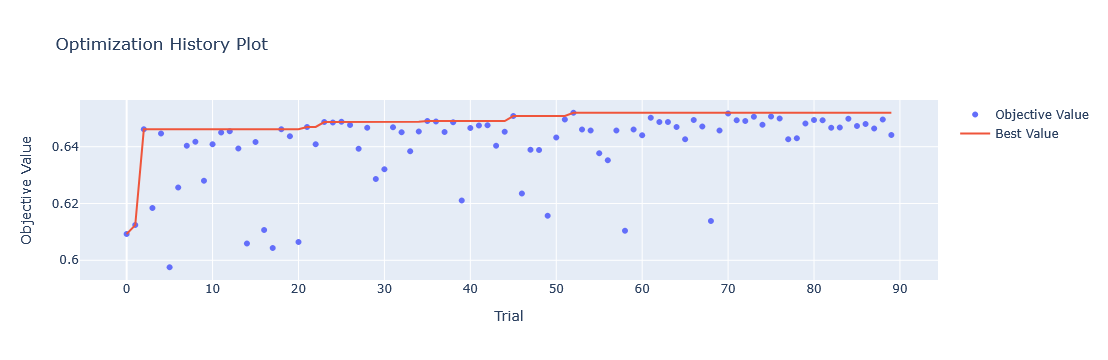

In [19]:
optuna.visualization.plot_optimization_history(study).show()

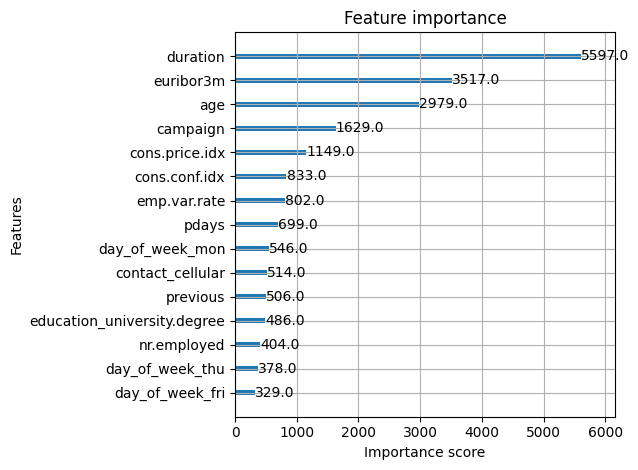

In [20]:
xgb.plot_importance(final_model, max_num_features=15)
plt.tight_layout()
plt.show()

In [26]:
y_pred_bin = (y_pred_proba >= 0.35).astype(int)
    
print(f'accuracy: {accuracy_score(y_test, y_pred_bin)}')
print(f'recall: {recall_score(y_test, y_pred_bin)}')
print(f'f1: {f1_score(y_test, y_pred_bin)}')
print(f'precision: {precision_score(y_test, y_pred_bin)}')
print(f'roc_auc {roc_auc_score(y_test, final_model.predict_proba(X_test_p)[:, 1])}')

accuracy: 0.8822958143148489
recall: 0.906896551724138
f1: 0.6344993968636912
precision: 0.48794063079777367
roc_auc 0.9528651504115514


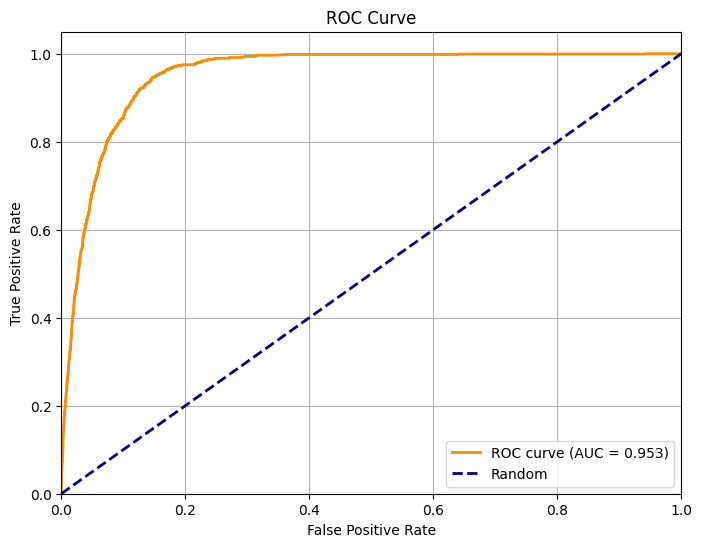

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test_p)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()